### Loading PDF Files

In [2]:
from langchain_community.document_loaders import PyPDFLoader

In [15]:
pdf_loader = PyPDFLoader('pdf.pdf')
documents = pdf_loader.load()
# print(documents)

In [5]:
type(documents)

list

### Text splitting (chunking), embeddings and vector storage
- usually documents are chunked such that it provides sufficient context to LLMs
- `chunk_size` parameter is used to control this balance
- `chunk_overlap` parameter is used to capture important information that may be lost around the boundaries between chunks

#### CharacterTextSplitter

In [12]:
from langchain_text_splitters import CharacterTextSplitter

text = str(documents[0])

text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=100,
    chunk_overlap=10
)

chunks = text_splitter.split_text(text)
# print(chunks)
print([len(chunk) for chunk in chunks])

Created a chunk of size 118, which is longer than the specified 100
Created a chunk of size 115, which is longer than the specified 100


[118, 115, 80, 91, 62, 51, 80, 64, 57, 56, 57, 56, 46, 60, 88, 56, 58, 100, 90, 52, 96, 84, 51, 68, 53, 52, 84, 68, 72, 65, 55, 71, 69, 69, 42, 73, 90, 76, 73, 99, 35, 74, 73, 77, 40, 75, 75, 77, 75, 74, 81, 71, 74, 76, 77, 55, 75, 70, 54, 95, 75, 73, 75, 76, 50, 94, 75, 77, 53, 70, 74, 68, 68, 69, 68, 37, 74, 63, 75, 71, 85, 70, 72, 38, 92, 76, 79, 91, 70, 79, 83, 57, 81, 99, 43, 182]


- CharacterTextSplitter frequently creates chunks that lack sufficient context to be useful in retrieval
- The method was also unable to create chunks that were all below the chunk_size by splitting by-paragraph
- We can improve on this with RecursiveCharacterTextSplitter.

#### RecursiveCharacterTextSplitter
- It takes a list of separators and recursively splits using each one, attempting to create chunks below chunk_size.
- For example, if the first separator creates chunks that exceed 100 characters, it will be split further using the next separator.
- RecursiveCharacterTextSplitter often preserves more context which will result in more coherent responses from our RAG application.

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=100,
    chunk_overlap=10
)

chunks = splitter.split_text(text)
# print(chunks)
print([len(chunk) for chunk in chunks])

[91, 13, 88, 11, 80, 91, 62, 51, 80, 64, 57, 56, 57, 56, 46, 60, 88, 56, 58, 56, 89, 95, 96, 84, 51, 68, 53, 52, 84, 68, 72, 65, 55, 71, 69, 69, 42, 73, 90, 76, 73, 89, 35, 74, 73, 77, 40, 75, 75, 77, 75, 74, 81, 71, 74, 76, 77, 55, 75, 70, 54, 95, 75, 73, 75, 76, 50, 94, 75, 77, 53, 70, 74, 68, 68, 69, 68, 37, 74, 63, 75, 71, 85, 70, 72, 38, 92, 76, 79, 91, 70, 79, 83, 57, 81, 99, 43, 98, 91]


### Splitting Documents
- Extending splitting strings to splitting documents requires just one change: swapping the `.split_text()` method to `.split_documents()`
- Each document has `.page_content` and `.metadata` attributes for extracting the respective information. Calculating the number of characters in each chunk, we can see that we were able to stay under the chunk size.

In [25]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

chunks = splitter.split_documents(documents)
# print(chunks)
print([len(chunk.page_content) for chunk in chunks])
# print([(chunk.metadata) for chunk in chunks])
print("Total number of chunks:"+str(len(chunks)))

[996, 980, 993, 992, 959, 957, 967, 988, 347, 961, 956, 937, 981, 964, 995, 235, 977, 965, 961, 961, 987, 962, 966, 266, 968, 954, 966, 293]
Total number of chunks:28


### Embedding and storing chunks
- embedding model from OpenAI and store the vectors in a Chroma vector database. Let's start by initializing the model.
- Then, to embed and store the chunks in one operation, we call the `.from_documents()` method on the Chroma class, passing the chunks and model
- if we were embedding string chunks, we'd use the `.from_texts()` method instead.

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    model="text-embedding-3-small"
)

vector_store = Chroma.from_documents(
    documents=chunks,
    embeddings=embedding_model
)

### Building an LCEL retrieval chain

#### Preparing data for retrieval
- Now we have our external data stored and ready for retrieval, it's time to create the **retrieval chain** to integrate it with an LLM!
- LangChain Expression Language, or LCEL, is a declarative syntax for defining chains suited from prototypes to production.
- It is particularly relevant to RAG systems because it creates modular, reusable pipelines that can combine retrieval and generation components together.
- The retrieval chain will take a question input,insert it into the chain using RunnablePassthrough and assign it to "question"
- RunnablePassthrough allows inputs to be inserted into chains unchanged.
- We retrieve the relevant documents from the vector store and assign to "context",integrate both of these into a prompt template,pass the prompt to the model to generate an output,and parse the output into our favored format, such as a string
- Before building the chain, we need to create three components: a retriever, which is derived from our vector store, a prompt template for combining the user question and retrieved context, and a model to generate the response.
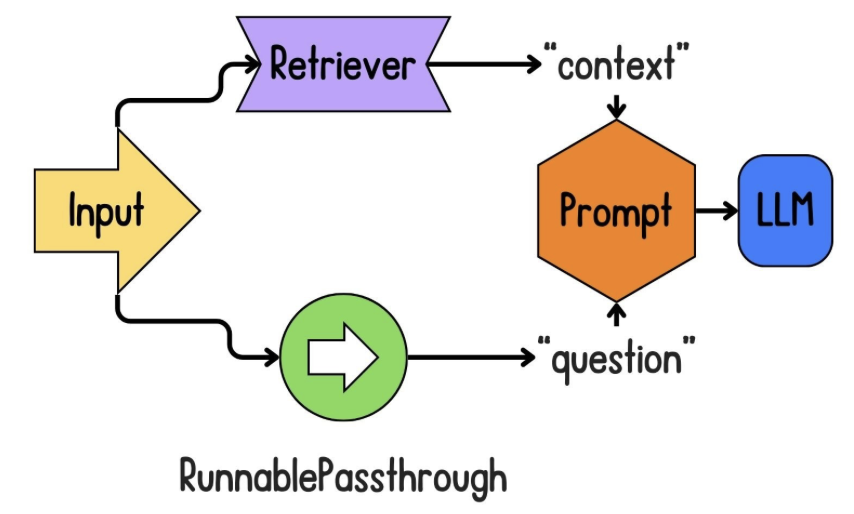

In [ ]:
#